In [1]:
import yfinance as yf

In [3]:
df = yf.download('AAPL',start="2018-01-01",end="2023-12-31",interval=" 1d")

C:\Users\Sameer\AppData\Local\Temp\ipykernel_20008\15592197.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL',start="2018-01-01",end="2023-12-31",interval=" 1d")
[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.380993,40.390372,39.677736,39.888715,102223600
2018-01-03,40.373959,40.917812,40.310668,40.444285,118071600
2018-01-04,40.561501,40.664645,40.338803,40.446634,89738400
2018-01-05,41.023300,41.110034,40.566184,40.657607,94640000
2018-01-08,40.870934,41.166300,40.772474,40.870934,82271200


In [8]:
df.columns

MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])

In [9]:
df.shape

(1509, 5)

In [10]:
df.columns = df.columns.droplevel(1) 
df.head()


Price,Close,High,Low,Open,Volume
Date,,,,,
2018-01-02,40.380993,40.390372,39.677736,39.888715,102223600
2018-01-03,40.373959,40.917812,40.310668,40.444285,118071600
2018-01-04,40.561501,40.664645,40.338803,40.446634,89738400
2018-01-05,41.023300,41.110034,40.566184,40.657607,94640000
2018-01-08,40.870934,41.166300,40.772474,40.870934,82271200


In [11]:
df.index.duplicated().sum()

np.int64(0)

In [ ]:
df = df[~df.index.duplicated(keep='first')]

In [12]:
df.isna().sum()

Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [ ]:
df = df.ffill()

In [13]:
df['MA50'] = df['Close'].rolling(window=50).mean()

In [14]:
df['MA200'] = df['Close'].rolling(window=200).mean()

In [15]:
print(df[['Close','MA50','MA200']].tail(10))

Price            Close        MA50       MA200
Date                                          
2023-12-15  195.911331  182.129779  175.693997
2023-12-18  194.245468  182.499322  175.919439
2023-12-19  195.286652  182.859978  176.136261
2023-12-20  193.194351  183.190673  176.353633
2023-12-21  193.045593  183.490466  176.563990
2023-12-22  191.974701  183.750817  176.780251
2023-12-26  191.429306  184.037099  177.004106
2023-12-27  191.528412  184.327939  177.218728
2023-12-28  191.954834  184.658403  177.425014
2023-12-29  190.913651  184.993988  177.624119


In [16]:
df['Signal'] = 0
df['Signal'][50:] = (df['MA50'][50:] > df['MA200'][50:]).astype(int) 

C:\Users\Sameer\AppData\Local\Temp\ipykernel_20008\1032994371.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Signal'][50:] = (df['MA50'][50:] > df['MA200'][50:]).astype(int)
C:\Users\Sameer\AppData\Local\Temp\ipykernel_20008\1032994

In [17]:
df['GoldenCross'] = df['Signal'].diff() == 1

In [18]:
golden_cross_dates = df.index[df['GoldenCross']]
print("Golden Cross dates:\n", golden_cross_dates)

Golden Cross dates:
 DatetimeIndex(['2018-10-16', '2019-05-06', '2022-09-26', '2023-03-22'], dtype='datetime64[ns]', name='Date', freq=None)


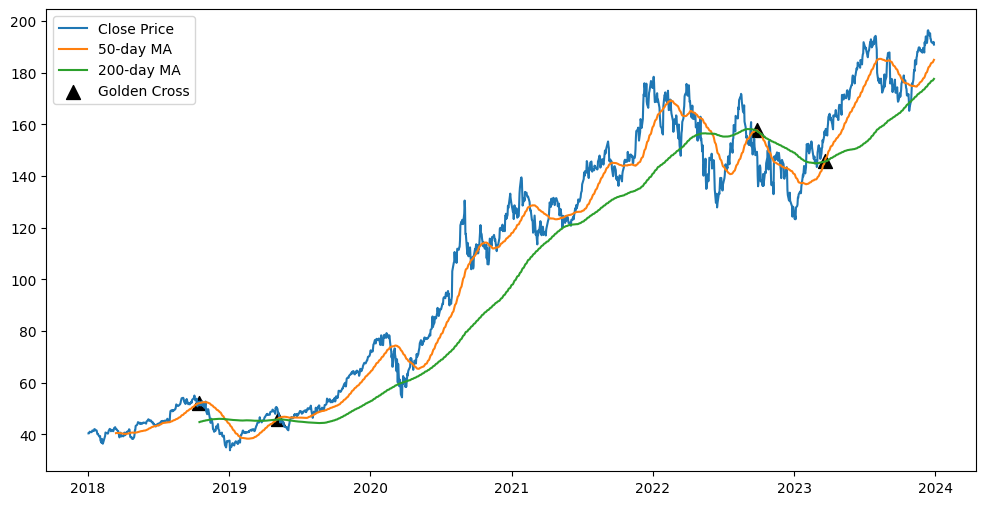

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price')
plt.plot(df['MA50'], label='50-day MA')
plt.plot(df['MA200'], label='200-day MA')
plt.scatter(df.index[df['GoldenCross']], df['MA50'][df['GoldenCross']], 
            marker='^', color='black', s=100, label='Golden Cross')
plt.legend()
plt.show()

In [21]:
golden_cross_dates = df.index[df['GoldenCross']]


In [22]:
budget = 5000
buy_date = golden_cross_dates[0]
buy_price = df.loc[buy_date, 'Close']

In [23]:
max_shares = budget // buy_price
print(f"Buy on {buy_date} at ${buy_price:.2f} per share. Max shares: {max_shares}")

Buy on 2018-10-16 00:00:00 at $52.67 per share. Max shares: 94.0


In [24]:
df['Signal'] = (df['MA50'] > df['MA200']).astype(int)  
df['DeathCross'] = df['Signal'].diff() == -1 

In [25]:
sell_date = df.index[(df['DeathCross']) & (df.index > buy_date)][0]
sell_price = df.loc[sell_date, 'Close']
print(f"Sell on {sell_date} at ${sell_price:.2f} per share")


Sell on 2018-12-21 00:00:00 at $35.86 per share


In [28]:
cash_after_sell = max_shares * sell_price
print(f"Cash after selling: ${cash_after_sell:.2f}")


Cash after selling: $3371.26


In [31]:
# Only force sell if we never sold yet (no death cross after buy)
if 'sell_date' not in locals() or sell_date <= buy_date:
    final_price = df['Close'].iloc[-1]
    final_cash = max_shares * final_price
    print(f"Force sell on last day {df.index[-1]} at ${final_price:.2f} per share")
    print(f"Final Cash after closing position: ${final_cash:.2f}")


In [32]:
if 'final_cash' in locals():
    profit_loss = final_cash - budget
else:
    profit_loss = cash_after_sell - budget

print(f"Profit/Loss: ${profit_loss:.2f}")

Profit/Loss: $12945.88
